In [1]:
import os 
import cv2
import numpy as np
from tqdm import tqdm
%matplotlib inline 

REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "resources/PetImages/Cat"
    DOGS = "resources/PetImages/Dog"
    LABELS = {CATS:0,DOGS:1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE,self.IMG_SIZE))
                    self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
        np.random.shuffle(self.training_data)
        np.save("resources/training_data.npy",self.training_data)
        print("Cats:",self.catcount)
        print("Dogs:",self.dogcount)

if REBUILD_DATA:
    dogsvscats = DogsVSCats()
    dogsvscats.make_training_data()

In [2]:
training_data = np.load("resources/training_data.npy", allow_pickle=True)

In [3]:
print(len(training_data))

24946


In [4]:
import matplotlib.pyplot as plt

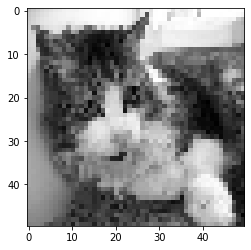

In [5]:
plt.imshow(training_data[12][0],cmap="gray")

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
            
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
    
        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512,2)
    
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        #print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1)

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

running on the GPU


In [8]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

2494
22452
2494


In [9]:
def fwd_pass(X,y,train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs,y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs,y)
    
    if train:
        loss.backward()
        optimizer.step()
    return acc,loss

In [10]:
def test(size = 32):
    idx = np.arange(test_X.shape[0])
    np.random.shuffle(idx)
    idx = idx[:size]
    X, y = test_X[idx],test_y[idx]
    with torch.no_grad():
        val_acc,val_loss = fwd_pass(X.view(-1,1,50,50).to(device),y.to(device))
    return val_acc, val_loss

In [11]:
import time

MODEL_NAME = f"model-{int(time.time())}"

net = Net().to(device)
optimizer = optim.Adam(net.parameters(),lr = 0.001)
loss_function = nn.BCELoss()

print(MODEL_NAME)

def train():
    BATCH_SIZE = 200
    EPOCHS = 30
    with open("model.log","a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0,len(train_X),BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)
                
                acc,loss = fwd_pass(batch_X,batch_y,train=True)
                
                if i % 50 == 0:
                    val_acc,  val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},\
                            {round(float(acc),2)},\
                            {round(float(loss),4)},\
                            {round(float(val_acc),2)},\
                            {round(float(val_loss),4)}\n")
            print(f"Epochs: {epoch} train_loss: {loss}")

train()

  2%|▏         | 2/113 [00:00<00:08, 13.81it/s]

model-1603542908


  2%|▏         | 2/113 [00:00<00:06, 17.56it/s]

Epochs: 0 train_loss: 0.6758238077163696


  2%|▏         | 2/113 [00:00<00:06, 17.64it/s]

Epochs: 1 train_loss: 0.6490966081619263


  2%|▏         | 2/113 [00:00<00:06, 16.06it/s]

Epochs: 2 train_loss: 0.6176223754882812


  2%|▏         | 2/113 [00:00<00:06, 15.96it/s]

Epochs: 3 train_loss: 0.5852891802787781


  2%|▏         | 2/113 [00:00<00:06, 16.48it/s]

Epochs: 4 train_loss: 0.5032787919044495


  2%|▏         | 2/113 [00:00<00:08, 13.10it/s]

Epochs: 5 train_loss: 0.47523611783981323


  2%|▏         | 2/113 [00:00<00:07, 15.31it/s]

Epochs: 6 train_loss: 0.4025152027606964


  2%|▏         | 2/113 [00:00<00:07, 15.79it/s]

Epochs: 7 train_loss: 0.36114272475242615


  2%|▏         | 2/113 [00:00<00:07, 15.66it/s]

Epochs: 8 train_loss: 0.32685229182243347


  2%|▏         | 2/113 [00:00<00:06, 15.92it/s]

Epochs: 9 train_loss: 0.3027311861515045


  2%|▏         | 2/113 [00:00<00:07, 15.48it/s]

Epochs: 10 train_loss: 0.24757836759090424


  2%|▏         | 2/113 [00:00<00:06, 15.96it/s]

Epochs: 11 train_loss: 0.24716238677501678


  2%|▏         | 2/113 [00:00<00:06, 16.40it/s]

Epochs: 12 train_loss: 0.17454731464385986


  2%|▏         | 2/113 [00:00<00:07, 14.53it/s]

Epochs: 13 train_loss: 0.1863487958908081


  2%|▏         | 2/113 [00:00<00:07, 15.57it/s]

Epochs: 14 train_loss: 0.157400980591774


  2%|▏         | 2/113 [00:00<00:08, 13.37it/s]

Epochs: 15 train_loss: 0.12077628076076508


  2%|▏         | 2/113 [00:00<00:07, 15.77it/s]

Epochs: 16 train_loss: 0.0837324857711792


  2%|▏         | 2/113 [00:00<00:07, 15.23it/s]

Epochs: 17 train_loss: 0.07542581856250763


  2%|▏         | 2/113 [00:00<00:07, 15.17it/s]

Epochs: 18 train_loss: 0.05482124909758568


  2%|▏         | 2/113 [00:00<00:07, 14.10it/s]

Epochs: 19 train_loss: 0.06549043953418732


  2%|▏         | 2/113 [00:00<00:07, 15.84it/s]

Epochs: 20 train_loss: 0.06817297637462616


  2%|▏         | 2/113 [00:00<00:08, 12.66it/s]

Epochs: 21 train_loss: 0.08506342768669128


  2%|▏         | 2/113 [00:00<00:07, 14.44it/s]

Epochs: 22 train_loss: 0.08620131015777588


  2%|▏         | 2/113 [00:00<00:07, 15.64it/s]

Epochs: 23 train_loss: 0.04297487437725067


  2%|▏         | 2/113 [00:00<00:07, 15.56it/s]

Epochs: 24 train_loss: 0.037113867700099945


  2%|▏         | 2/113 [00:00<00:08, 13.55it/s]

Epochs: 25 train_loss: 0.036582689732313156


  2%|▏         | 2/113 [00:00<00:08, 13.64it/s]

Epochs: 26 train_loss: 0.06719937175512314


  2%|▏         | 2/113 [00:00<00:07, 14.60it/s]

Epochs: 27 train_loss: 0.07120201736688614


  2%|▏         | 2/113 [00:00<00:06, 16.00it/s]

Epochs: 28 train_loss: 0.06171523407101631


100%|██████████| 113/113 [00:07<00:00, 15.82it/s]

Epochs: 29 train_loss: 0.03885878250002861


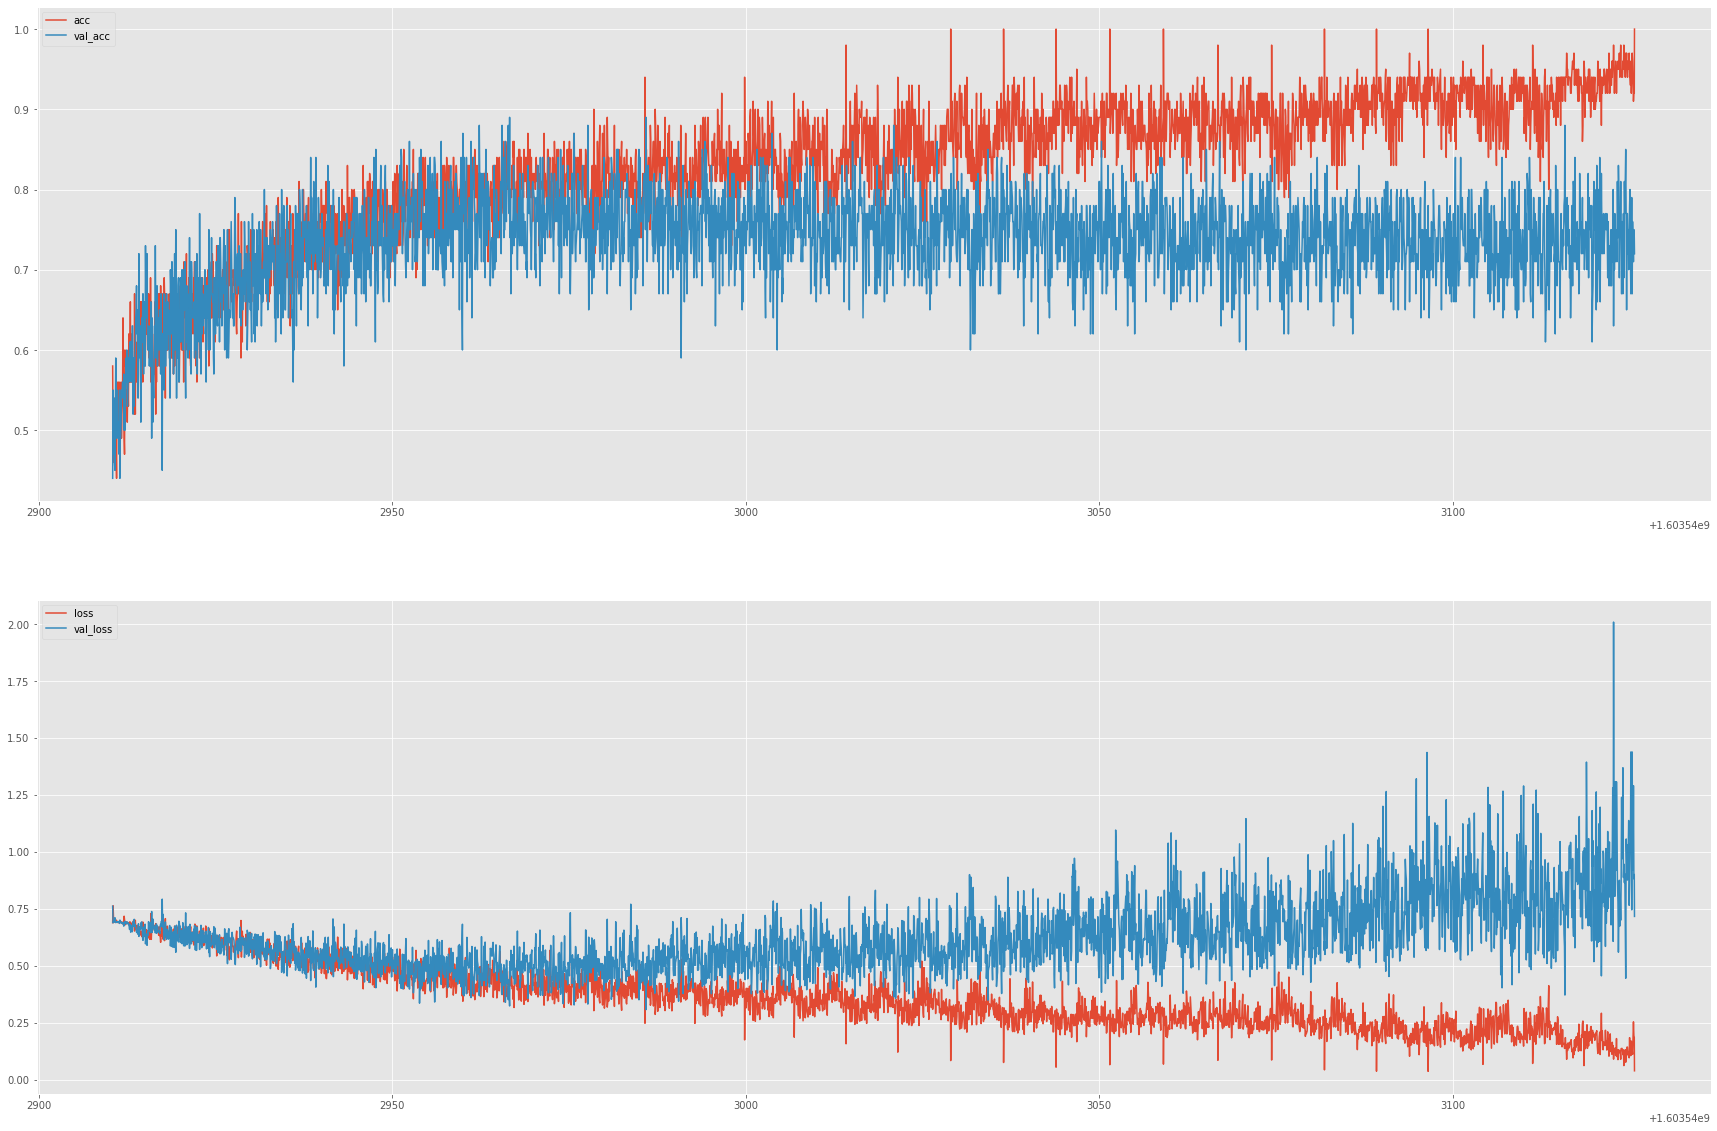

In [15]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")
model_name = "model-1603542908"

def create_acc_loss_graph(model_name):
    contents = open("model.log",  "r").read().split('\n')
    
    times = []
    accuracies =[]
    losses = []
    
    val_accs = []
    val_losses = []
    
    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
            
            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))
            
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))
    
    fig = plt.figure(figsize=(30,20))
    
    ax1 = plt.subplot2grid((2,1),(0,0))
    ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)
    
    ax1.plot(times,accuracies,label="acc")
    ax1.plot(times,val_accs,label="val_acc")
    ax1.legend(loc=2)
    
    ax2.plot(times,losses,label="loss")
    ax2.plot(times,val_losses,label="val_loss")
    ax2.legend(loc=2)
    
    plt.show()
    
create_acc_loss_graph(model_name)